In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [12]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

## Generator

In [13]:
def build_generator(img_shape, z_dim):

    model = Sequential()
    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))
    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))
    # Output layer with tanh activation
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))
    return model

## Discriminator

In [14]:
def build_discriminator(img_shape):
    model = Sequential()
    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))
    # Fully connected layer
    model.add(Dense(128))
    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))
    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))
    return model

## Build the Model

In [15]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [16]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## Training

In [19]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        # 노이즈 추가시키기
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [20]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Train the GAN and Inspect Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

1000 [D loss: 0.059538, acc.: 99.22%] [G loss: 3.206509]
2000 [D loss: 0.123129, acc.: 95.70%] [G loss: 3.923971]
3000 [D loss: 0.123515, acc.: 95.31%] [G loss: 4.475592]
4000 [D loss: 0.223297, acc.: 92.19%] [G loss: 4.457919]
5000 [D loss: 0.142583, acc.: 95.31%] [G loss: 5.158818]
6000 [D loss: 0.233786, acc.: 88.67%] [G loss: 3.628465]
7000 [D loss: 0.300484, acc.: 85.16%] [G loss: 3.252439]
8000 [D loss: 0.357153, acc.: 83.59%] [G loss: 2.771949]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\01_Program\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-0582caae7556>", line 7, in <module>
    train(iterations, batch_size, sample_interval)
  File "<ipython-input-19-f2fd8d8fced5>", line 37, in train
    d_loss_real = discriminator.train_on_batch(imgs, real)
  File "D:\01_Program\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 973, in train_on_batch
    class_weight=class_weight, reset_metrics=reset_metrics)
  File "D:\01_Program\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_v2_utils.py", line 264, in train_on_batch
    output_loss_metrics=model._output_loss_metrics)
  File "D:\01_Program\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_eager.py", line 311, in train_on_batch
    output_loss_metrics=output_loss_metrics))
  File "D:\01_

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000020FB07678C8> (for post_execute):


KeyboardInterrupt: 

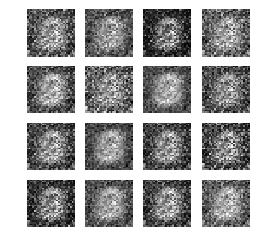

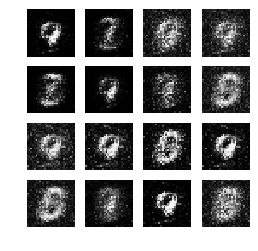

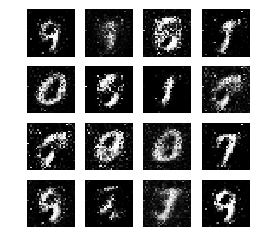

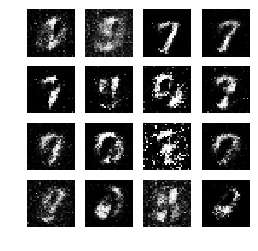

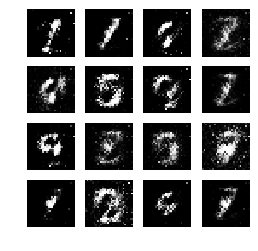

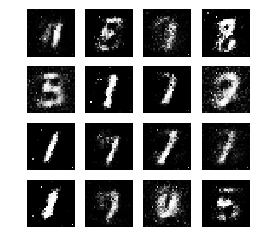

Error in callback <function flush_figures at 0x0000020FB07732F0> (for post_execute):


KeyboardInterrupt: 

In [21]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

In [ ]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [ ]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

----